In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/elio_samaha/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
df = pd.read_csv("train_tweets/PortugalGhana58.csv")
df.shape

(272389, 6)

In [4]:
df.head(), df.tail()

(    ID  MatchID  PeriodID  EventType      Timestamp  \
 0  3_0        3         0          0  1403797800000   
 1  3_0        3         0          0  1403797800000   
 2  3_0        3         0          0  1403797800000   
 3  3_0        3         0          0  1403797800000   
 4  3_0        3         0          0  1403797800000   
 
                                                Tweet  
 0  @Gucci_waley  #worldcup #POR vs #GHA live in h...  
 1  RT @Deadspin: Your live streaming links for Un...  
 2  WORLD CUP 2014\n#SWC14\n\nMatch 45: Thursday, ...  
 3  RT @SportsCenter: #USA advances with a win or ...  
 4  Cried a little....the USA and Ghana matches ar...  ,
            ID  MatchID  PeriodID  EventType      Timestamp  \
 272384  3_129        3       129          1  1403805600000   
 272385  3_129        3       129          1  1403805600000   
 272386  3_129        3       129          1  1403805600000   
 272387  3_129        3       129          1  1403805600000   
 272388  3

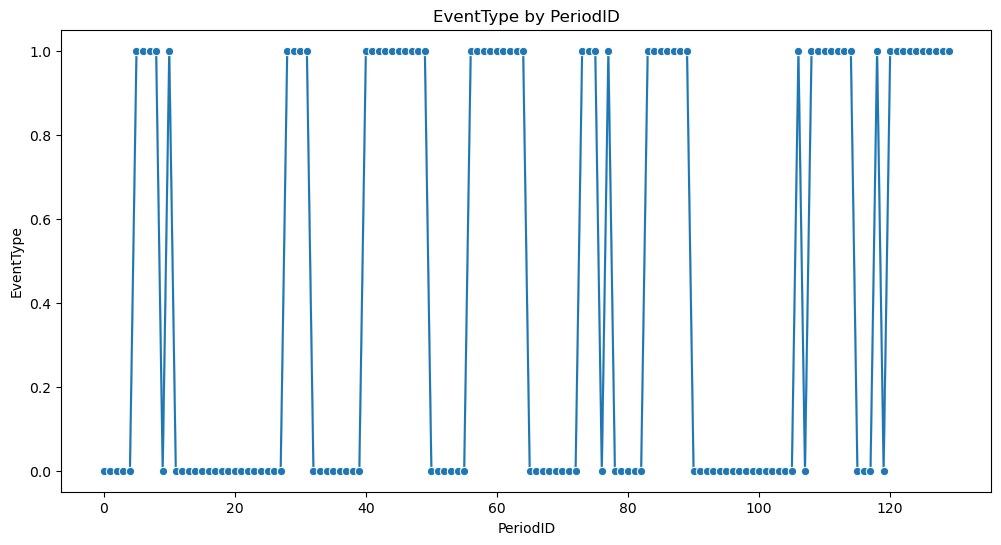

In [15]:
# Ensure the periodID and EventType columns are in the dataframe
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='PeriodID', y='EventType', marker='o')
plt.title('EventType by PeriodID')
plt.xlabel('PeriodID')
plt.ylabel('EventType')
plt.show()

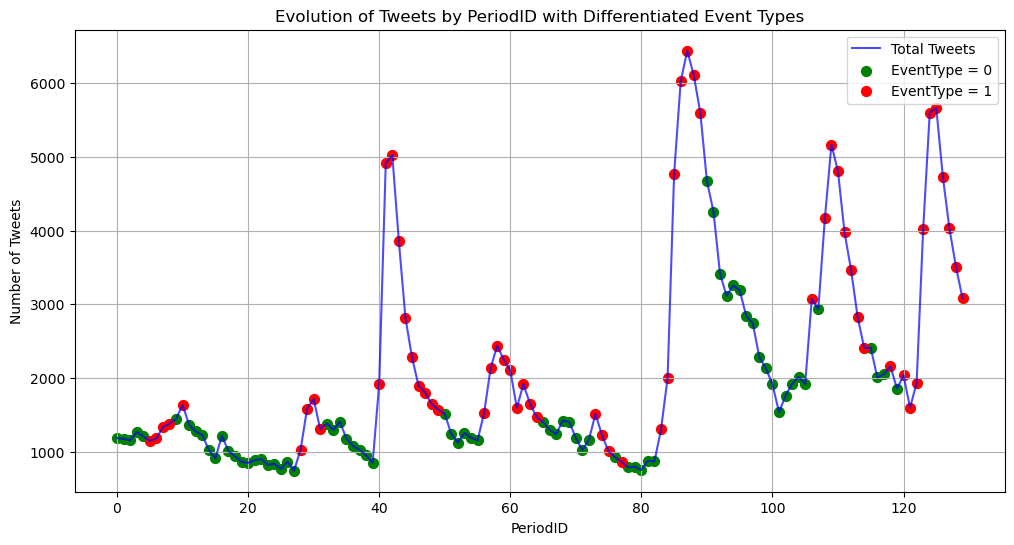

In [ ]:
import matplotlib.pyplot as plt

# Group data by PeriodID and EventType to calculate the number of tweets
tweet_counts = df.groupby(['PeriodID', 'EventType']).size().reset_index(name='TweetCount')

# Remove rows where the number of tweets is zero
tweet_counts = tweet_counts[tweet_counts['TweetCount'] > 0]

# Separate the data for EventType = 0 and EventType = 1
event_0 = tweet_counts[tweet_counts['EventType'] == 0]
event_1 = tweet_counts[tweet_counts['EventType'] == 1]

# Plot the evolution of tweets
plt.figure(figsize=(12, 6))

# Plot the line showing the total trend (combining both EventType = 0 and EventType = 1)
plt.plot(
    tweet_counts['PeriodID'], 
    tweet_counts['TweetCount'], 
    label="Total Tweets", 
    color="blue", 
    alpha=0.7
)

# Highlight EventType = 0 and EventType = 1
plt.scatter(event_0['PeriodID'], event_0['TweetCount'], color="green", label="EventType = 0", s=50)
plt.scatter(event_1['PeriodID'], event_1['TweetCount'], color="red", label="EventType = 1", s=50)

# Add labels, title, and legend
plt.title("Evolution of Tweets by PeriodID with Differentiated Event Types")
plt.xlabel("PeriodID")
plt.ylabel("Number of Tweets")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

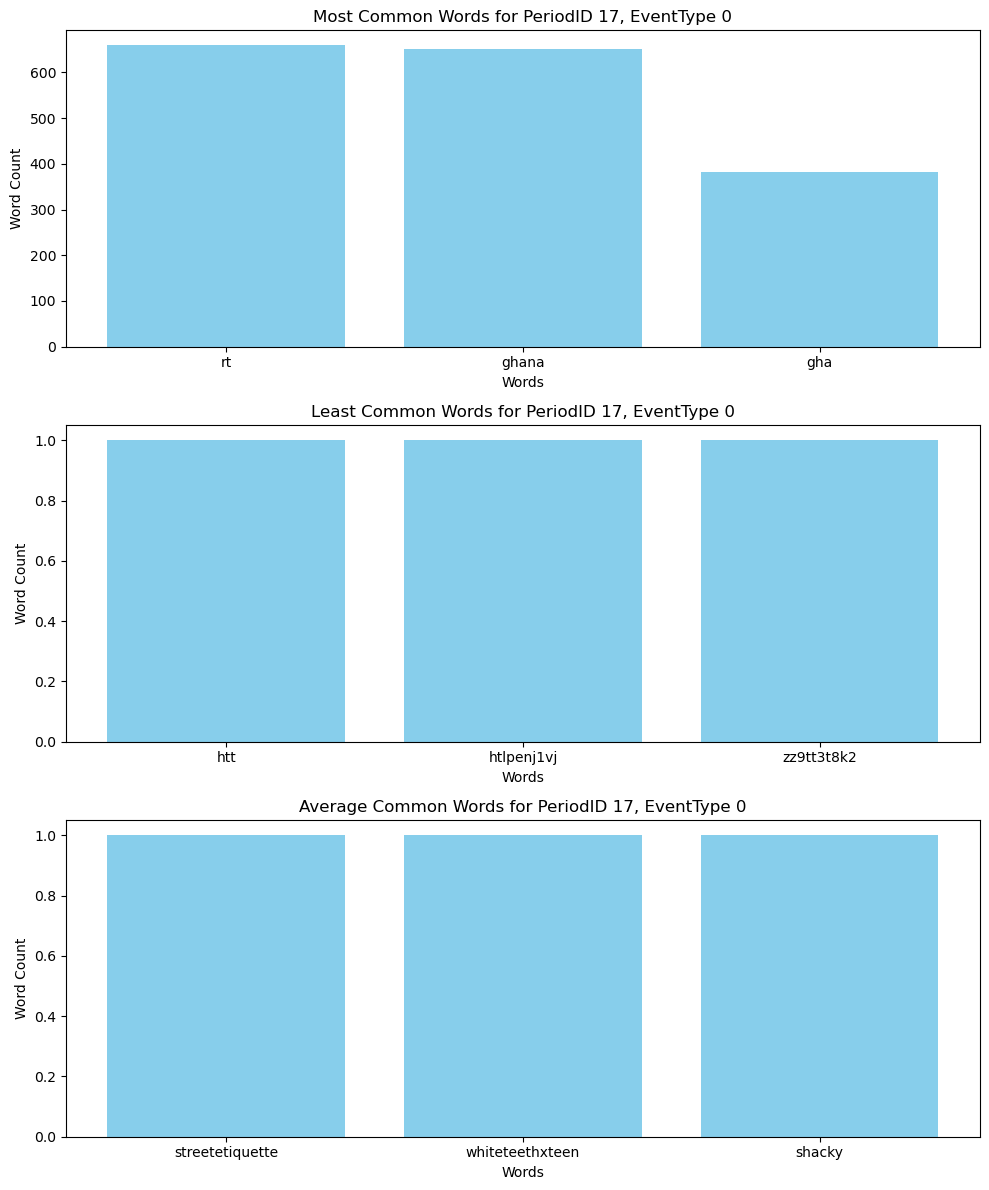

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Define stop words and preprocessing
stop_words_list = list(stopwords.words('english'))  # Convert stop words to a list

# Function to preprocess and extract word frequencies
def extract_word_frequencies(df, period_id, event_type):
    # Filter tweets for the given PeriodID and EventType
    period_tweets = df[(df['PeriodID'] == period_id) & (df['EventType'] == event_type)]['Tweet']
    
    # Drop empty strings or NaN values
    period_tweets = period_tweets.dropna()
    period_tweets = period_tweets[period_tweets.str.strip() != ""]

    # Check if there are any valid tweets to process
    if period_tweets.empty:
        return {
            'most_common': pd.DataFrame({'word': [], 'count': []}),
            'least_common': pd.DataFrame({'word': [], 'count': []}),
            'avg_common': pd.DataFrame({'word': [], 'count': []})
        }
    
    # Tokenize and count word frequencies
    vectorizer = CountVectorizer(stop_words=stop_words_list, lowercase=True)
    try:
        word_counts = vectorizer.fit_transform(period_tweets)
        word_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(),
                                  'count': word_counts.toarray().sum(axis=0)})
    except ValueError:
        print(f"No valid vocabulary for PeriodID={period_id}, EventType={event_type}")
        return {
            'most_common': pd.DataFrame({'word': [], 'count': []}),
            'least_common': pd.DataFrame({'word': [], 'count': []}),
            'avg_common': pd.DataFrame({'word': [], 'count': []})
        }
    
    # Sort frequencies
    sorted_freq = word_freq.sort_values(by='count', ascending=False)
    return {
        'most_common': sorted_freq.head(3),
        'least_common': sorted_freq.tail(3),
        'avg_common': sorted_freq.iloc[len(sorted_freq) // 2 - 1: len(sorted_freq) // 2 + 2]
    }

# Analyze word frequencies by PeriodID and EventType
word_analysis = {}
for period_id in df['PeriodID'].unique():
    for event_type in df['EventType'].unique():
        key = f"PeriodID-{period_id}_EventType-{event_type}"
        word_analysis[key] = extract_word_frequencies(df, period_id, event_type)

# Plot example for one PeriodID and EventType
period_id_example = 17
event_type_example = 0
key_example = f"PeriodID-{period_id_example}_EventType-{event_type_example}"
word_data = word_analysis[key_example]

# Plot bar charts for most, least, and average common words
if not word_data['most_common'].empty:
    fig, ax = plt.subplots(3, 1, figsize=(10, 12))
    categories = ['most_common', 'least_common', 'avg_common']
    titles = ['Most Common Words', 'Least Common Words', 'Average Common Words']

    for i, category in enumerate(categories):
        ax[i].bar(word_data[category]['word'], word_data[category]['count'], color='skyblue')
        ax[i].set_title(f"{titles[i]} for PeriodID {period_id_example}, EventType {event_type_example}")
        ax[i].set_ylabel('Word Count')
        ax[i].set_xlabel('Words')
    plt.tight_layout()
    plt.show()
else:
    print(f"No valid words to plot for PeriodID={period_id_example}, EventType={event_type_example}")

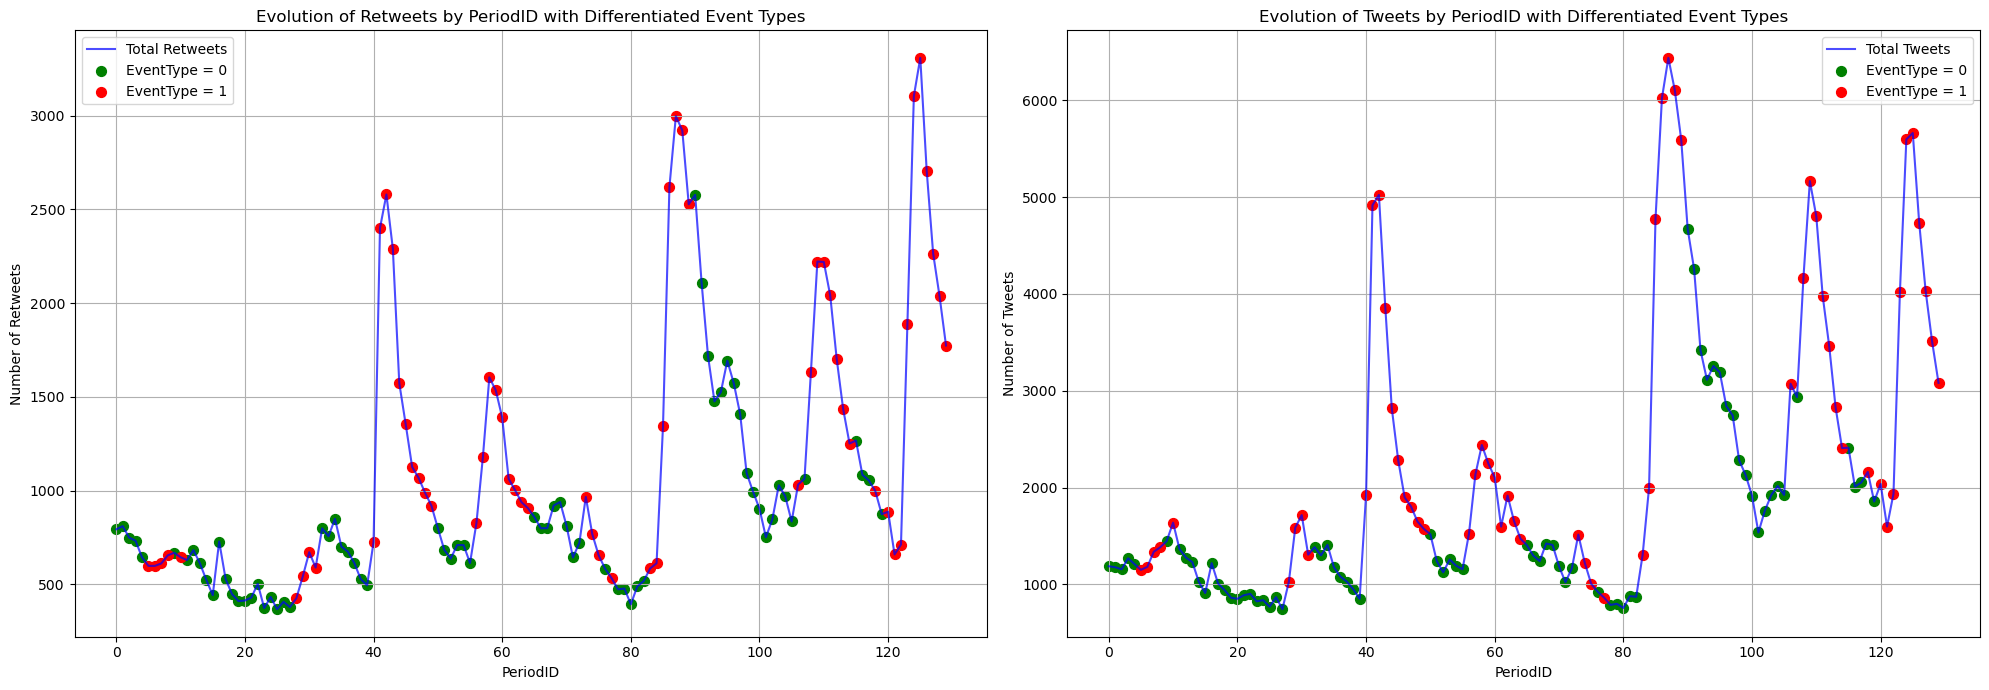

In [25]:
import matplotlib.pyplot as plt

# Filter the dataframe to include only retweets
retweets_df = df[df['Tweet'].str.contains('RT')]

# Group data by PeriodID and EventType to calculate the number of retweets
retweet_counts = retweets_df.groupby(['PeriodID', 'EventType']).size().reset_index(name='RetweetCount')

# Remove rows where the number of retweets is zero
retweet_counts = retweet_counts[retweet_counts['RetweetCount'] > 0]

# Separate the data for EventType = 0 and EventType = 1 for retweets
retweets_event_0 = retweet_counts[retweet_counts['EventType'] == 0]
retweets_event_1 = retweet_counts[retweet_counts['EventType'] == 1]

# Group data by PeriodID and EventType to calculate the number of tweets
tweet_counts = df.groupby(['PeriodID', 'EventType']).size().reset_index(name='TweetCount')

# Remove rows where the number of tweets is zero
tweet_counts = tweet_counts[tweet_counts['TweetCount'] > 0]

# Separate the data for EventType = 0 and EventType = 1 for tweets
event_0 = tweet_counts[tweet_counts['EventType'] == 0]
event_1 = tweet_counts[tweet_counts['EventType'] == 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot the retweets evolution
axes[0].plot(
    retweet_counts['PeriodID'], 
    retweet_counts['RetweetCount'], 
    label="Total Retweets", 
    color="blue", 
    alpha=0.7
)
axes[0].scatter(retweets_event_0['PeriodID'], retweets_event_0['RetweetCount'], color="green", label="EventType = 0", s=50)
axes[0].scatter(retweets_event_1['PeriodID'], retweets_event_1['RetweetCount'], color="red", label="EventType = 1", s=50)
axes[0].set_title("Evolution of Retweets by PeriodID with Differentiated Event Types")
axes[0].set_xlabel("PeriodID")
axes[0].set_ylabel("Number of Retweets")
axes[0].legend()
axes[0].grid(True)

# Plot the tweets evolution
axes[1].plot(
    tweet_counts['PeriodID'], 
    tweet_counts['TweetCount'], 
    label="Total Tweets", 
    color="blue", 
    alpha=0.7
)
axes[1].scatter(event_0['PeriodID'], event_0['TweetCount'], color="green", label="EventType = 0", s=50)
axes[1].scatter(event_1['PeriodID'], event_1['TweetCount'], color="red", label="EventType = 1", s=50)
axes[1].set_title("Evolution of Tweets by PeriodID with Differentiated Event Types")
axes[1].set_xlabel("PeriodID")
axes[1].set_ylabel("Number of Tweets")
axes[1].legend()
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()

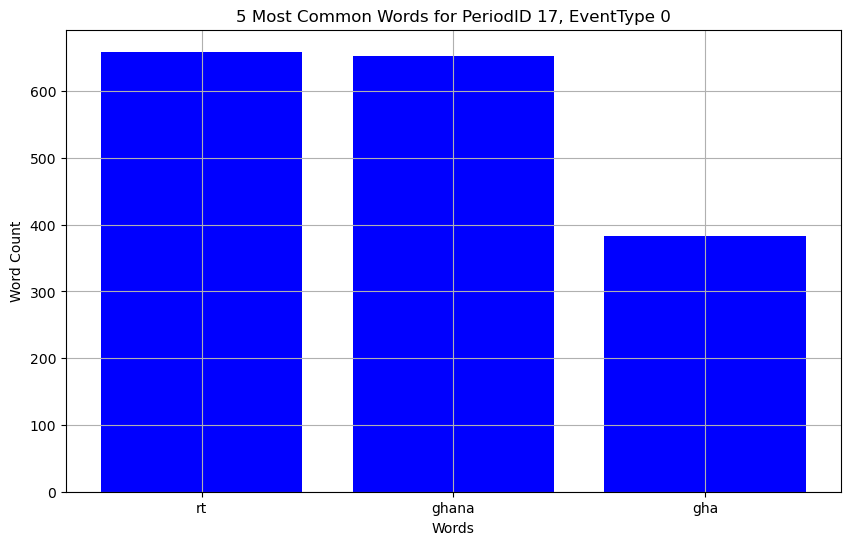

In [28]:
import matplotlib.pyplot as plt

# Define a function to plot the 5 most common words for a specific PeriodID
def plot_most_common_words(word_analysis, period_id, event_type):
    key = f"PeriodID-{period_id}_EventType-{event_type}"
    word_data = word_analysis[key]

    if not word_data['most_common'].empty:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(word_data['most_common']['word'], word_data['most_common']['count'], color='blue')
        ax.set_title(f"5 Most Common Words for PeriodID {period_id}, EventType {event_type}")
        ax.set_ylabel('Word Count')
        ax.set_xlabel('Words')
        plt.grid(True)
        plt.show()
    else:
        print(f"No valid words to plot for PeriodID={period_id}, EventType={event_type}")

# Example usage
plot_most_common_words(word_analysis, period_id=17, event_type=0)

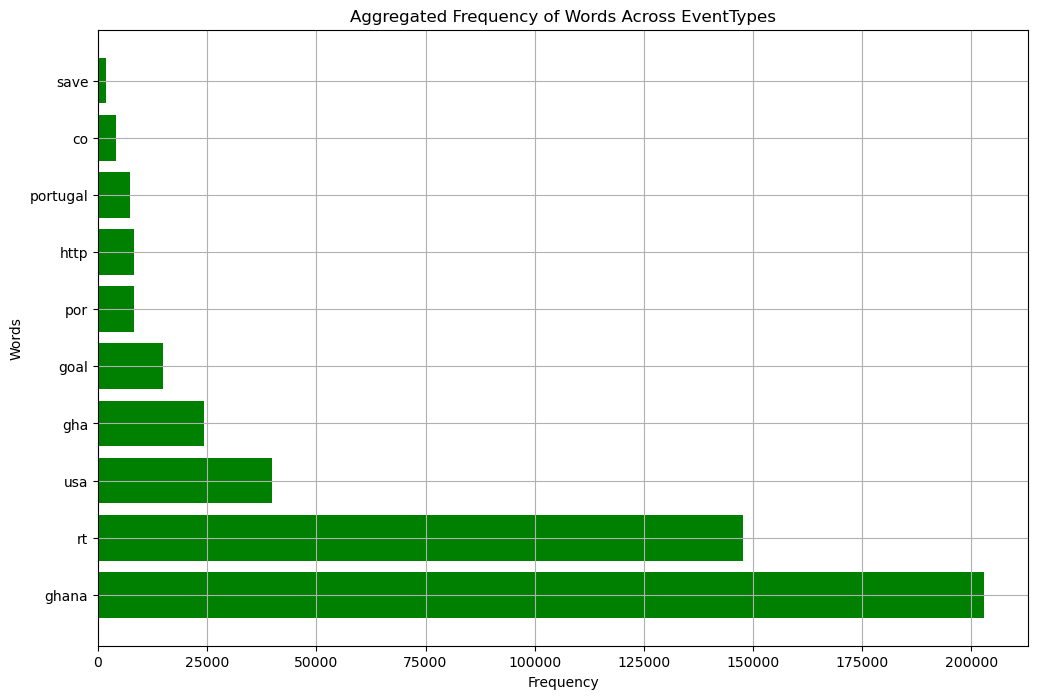

In [29]:
# Aggregate word frequencies across all PeriodIDs and EventTypes
aggregated_words = pd.DataFrame()
for key, analysis in word_analysis.items():
    event_type = int(key.split('_')[-1].split('-')[-1])
    if not analysis['most_common'].empty:
        analysis['most_common']['EventType'] = event_type
        aggregated_words = pd.concat([aggregated_words, analysis['most_common']], ignore_index=True)

# Group by word and analyze frequencies across EventTypes
word_frequencies = aggregated_words.groupby('word').agg({
    'count': 'sum',
    'EventType': lambda x: list(x)
}).reset_index()

# Add a column to determine if a word appears in both EventTypes
word_frequencies['Appears_in_Both'] = word_frequencies['EventType'].apply(lambda x: len(set(x)) > 1)

# Visualization of aggregated word frequencies
plt.figure(figsize=(12, 8))
word_frequencies_sorted = word_frequencies.sort_values(by='count', ascending=False).head(10)
plt.barh(word_frequencies_sorted['word'], word_frequencies_sorted['count'], color='green')
plt.title("Aggregated Frequency of Words Across EventTypes")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.grid(True)
plt.show()

/home/elio_samaha/miniconda3/envs/cv_lab1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


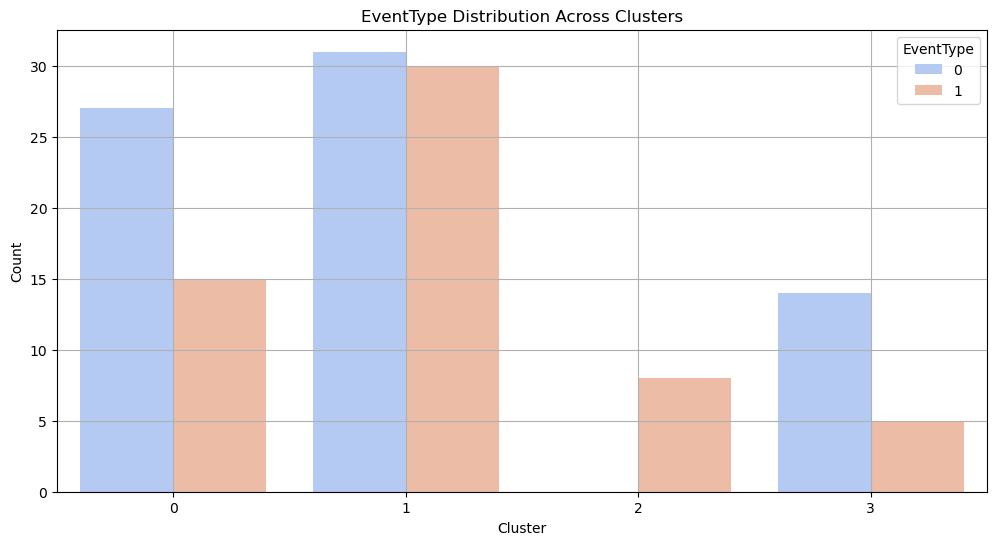

### Cluster 0
Top Words:
word
ghana       39090
rt          36283
gha         22972
co              0
goal            0
http            0
por             0
portugal        0
pts             0
ronaldo         0
dtype: int64

EventType Distribution:
EventType
0    0.642857
1    0.357143
Name: proportion, dtype: float64


### Cluster 1
Top Words:
word
ghana       129639
rt           86490
usa          39958
por           8278
portugal      4692
co            4038
save          1785
pts            804
ronaldo        545
gha              0
dtype: int64

EventType Distribution:
EventType
0    0.508197
1    0.491803
Name: proportion, dtype: float64


### Cluster 2
Top Words:
word
ghana       19538
goal        14984
rt          11161
portugal     2675
co              0
gha             0
http            0
por             0
pts             0
ronaldo         0
dtype: int64

EventType Distribution:
EventType
1    1.0
Name: proportion, dtype: float64


### Cluster 3
Top Words:
word
ghana       1458

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Combine most common words for all PeriodID-EventType combinations
def gather_most_common_words(word_analysis):
    combined_data = pd.DataFrame()
    for key, analysis in word_analysis.items():
        if not analysis['most_common'].empty:
            period_id = int(key.split('-')[1].split('_')[0])
            event_type = int(key.split('_')[-1].split('-')[-1])
            analysis['most_common']['PeriodID'] = period_id
            analysis['most_common']['EventType'] = event_type
            combined_data = pd.concat([combined_data, analysis['most_common']], ignore_index=True)
    return combined_data

# Gather data
all_most_common_words = gather_most_common_words(word_analysis)

# Pivot to create a feature matrix for clustering
word_pivot = all_most_common_words.pivot_table(
    index=['PeriodID', 'EventType'],
    columns='word',
    values='count',
    aggfunc='sum',
    fill_value=0
)

# Add EventType back for analysis
word_pivot = word_pivot.reset_index()

# Normalize using TF-IDF for clustering
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform([' '.join([f"{word} " * int(count) for word, count in row.items()])
                                     for _, row in word_pivot.drop(columns=['PeriodID', 'EventType']).iterrows()])

# Apply KMeans clustering
num_clusters = 4  # Number of clusters can be adjusted
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Add cluster labels to the data
word_pivot['Cluster'] = clusters

# Visualize distribution of EventTypes within each cluster
cluster_eventtype_dist = word_pivot.groupby(['Cluster', 'EventType']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_eventtype_dist, x='Cluster', y='Count', hue='EventType', palette='coolwarm')
plt.title("EventType Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="EventType")
plt.grid(True)
plt.show()

# Insights per cluster
cluster_insights = {}
for cluster in range(num_clusters):
    cluster_data = word_pivot[word_pivot['Cluster'] == cluster]
    cluster_words = cluster_data.drop(columns=['PeriodID', 'EventType', 'Cluster']).sum().sort_values(ascending=False).head(10)
    eventtype_distribution = cluster_data['EventType'].value_counts(normalize=True)
    cluster_insights[f"Cluster {cluster}"] = {
        'Top Words': cluster_words,
        'EventType Distribution': eventtype_distribution
    }

# Display insights
for cluster, insights in cluster_insights.items():
    print(f"### {cluster}")
    print("Top Words:")
    print(insights['Top Words'])
    print("\nEventType Distribution:")
    print(insights['EventType Distribution'])
    print("\n")

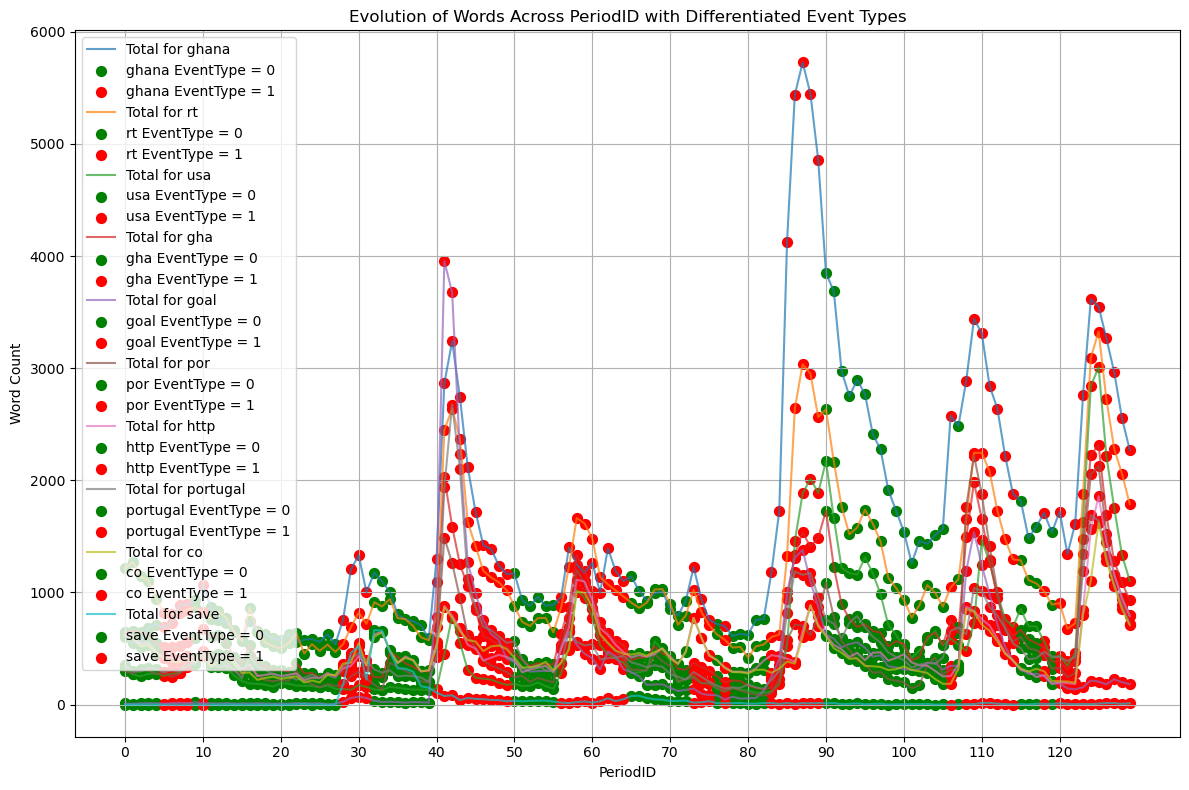

In [36]:
import matplotlib.pyplot as plt

# Select 5–10 most common meaningful words
meaningful_words = word_frequencies_sorted['word'].tolist()

# Track evolution of these words over PeriodID
word_evolution = pd.DataFrame()
for word in meaningful_words:
    for period_id in df['PeriodID'].unique():
        for event_type in df['EventType'].unique():
            tweets = df[(df['PeriodID'] == period_id) & (df['EventType'] == event_type)]['Tweet']
            if not tweets.empty:
                vectorizer = CountVectorizer(vocabulary=[word], stop_words=stop_words_list, lowercase=True)
                word_count = vectorizer.fit_transform(tweets).toarray().sum()
                word_evolution = pd.concat([word_evolution, pd.DataFrame({
                    'PeriodID': [period_id],
                    'EventType': [event_type],
                    'Word': [word],
                    'Count': [word_count]
                })], ignore_index=True)

# Plot the evolution of words across PeriodID with one line per word
plt.figure(figsize=(12, 8))

for word in meaningful_words:
    word_data = word_evolution[word_evolution['Word'] == word]
    # Plot the combined trend line for the word
    plt.plot(
        word_data['PeriodID'], 
        word_data['Count'], 
        label=f"Total for {word}", 
        alpha=0.7
    )
    # Highlight EventType = 0 and EventType = 1 for the word
    event_0 = word_data[word_data['EventType'] == 0]
    event_1 = word_data[word_data['EventType'] == 1]
    plt.scatter(event_0['PeriodID'], event_0['Count'], color="green", label=f"{word} EventType = 0", s=50)
    plt.scatter(event_1['PeriodID'], event_1['Count'], color="red", label=f"{word} EventType = 1", s=50)

# Add labels, title, and legend
plt.title("Evolution of Words Across PeriodID with Differentiated Event Types")
plt.xlabel("PeriodID")
plt.ylabel("Word Count")
plt.legend()
plt.grid(True)

# Set x-ticks to show multiples of 5
plt.xticks(range(0, int(word_evolution['PeriodID'].max()) + 1, 10))

# Show the plot
plt.tight_layout()
plt.show()

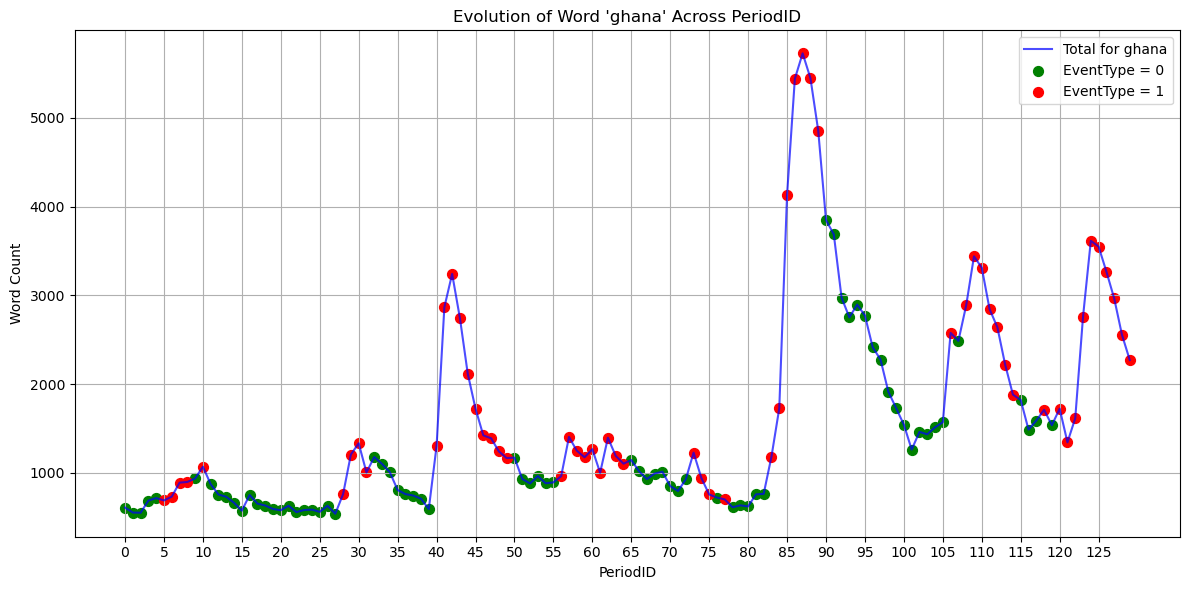

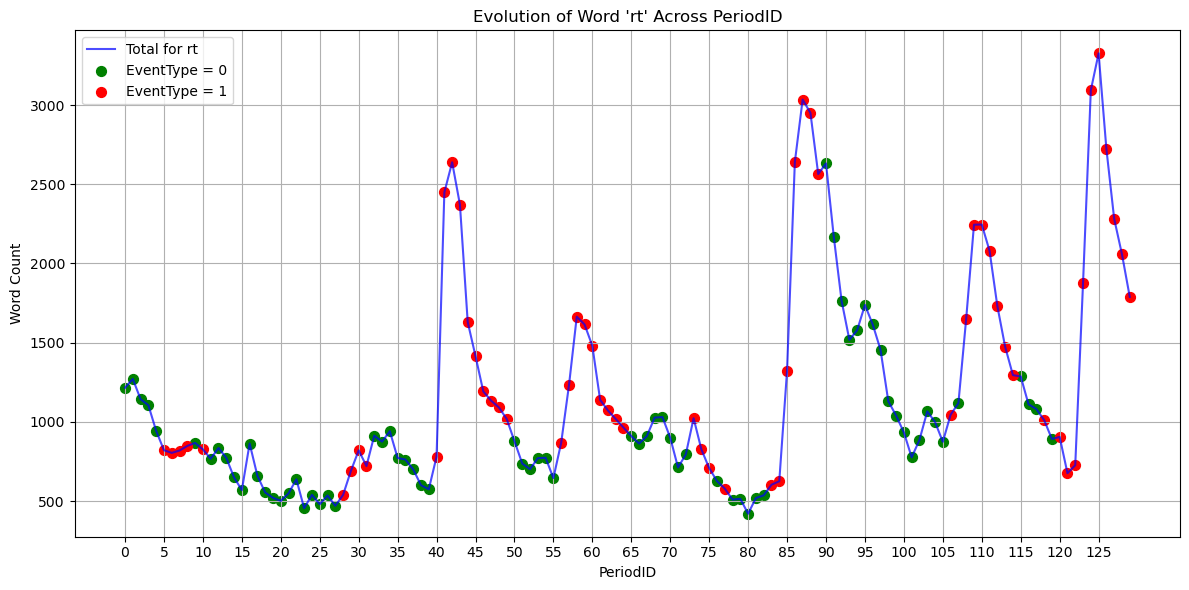

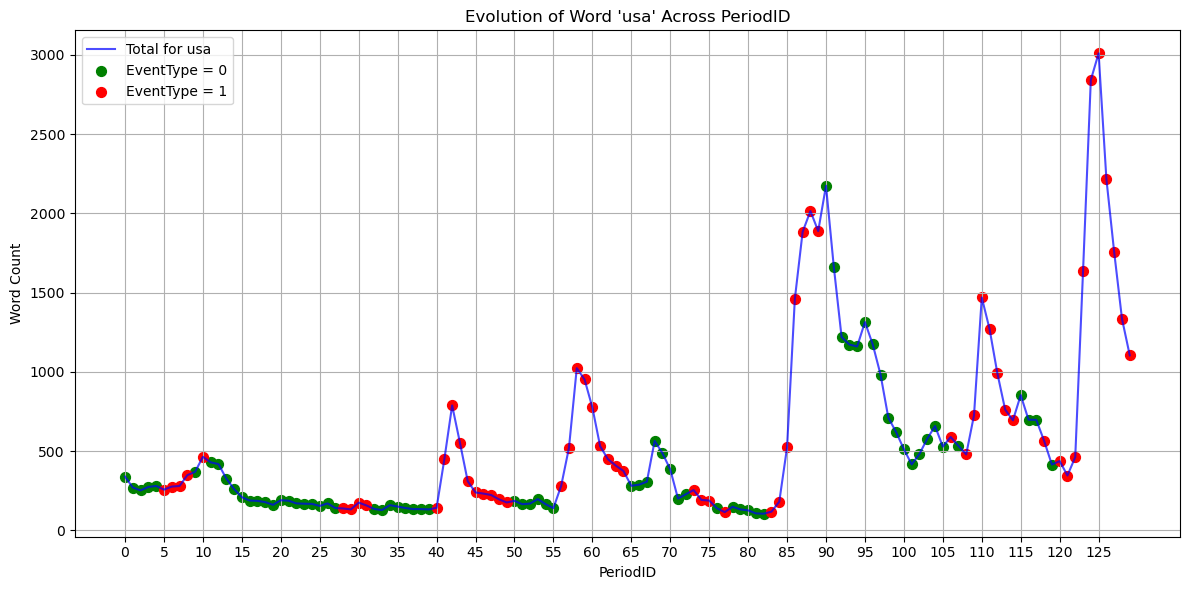

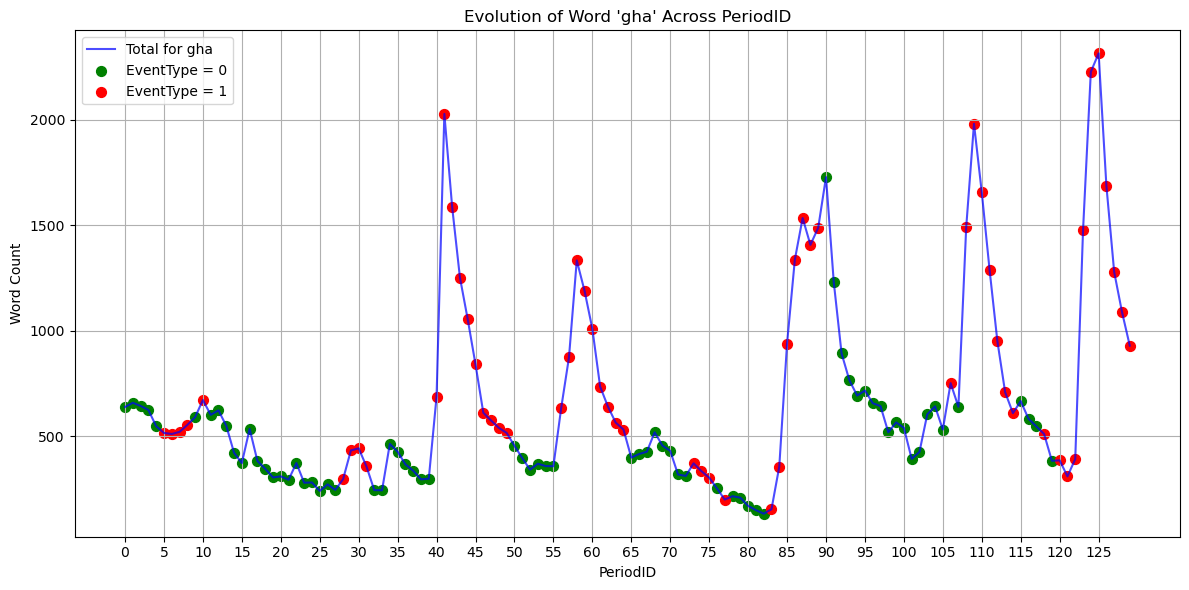

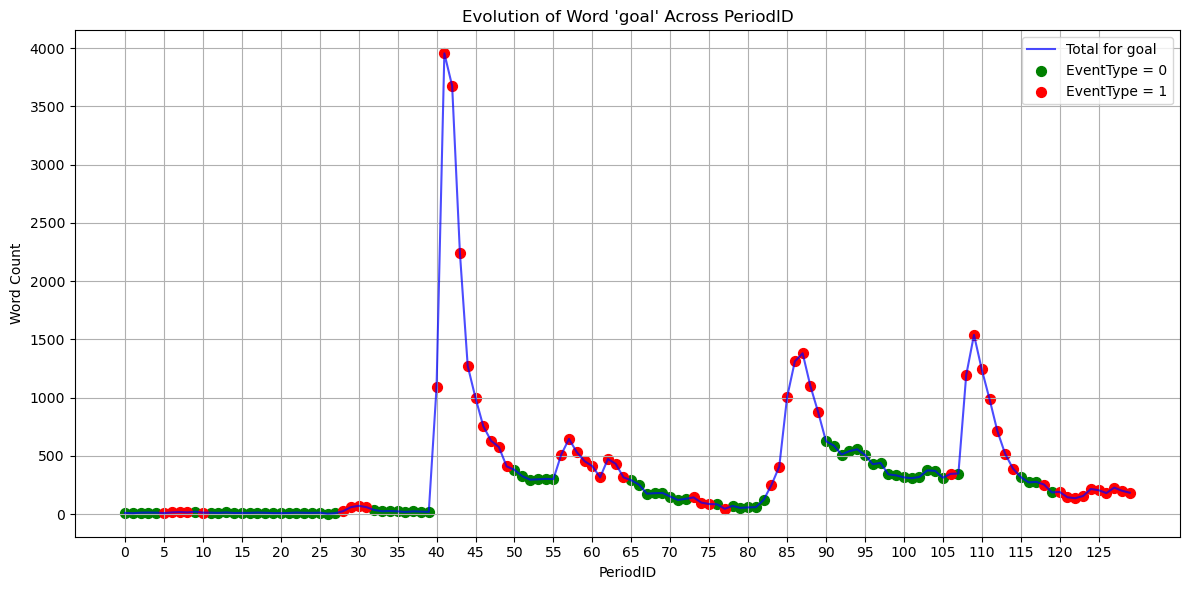

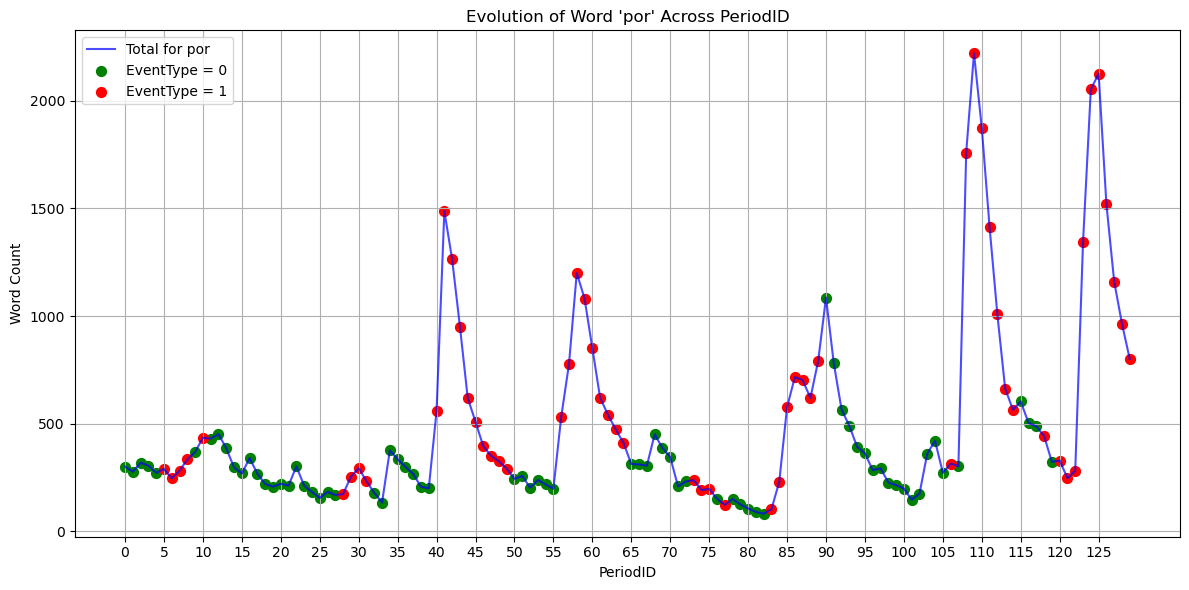

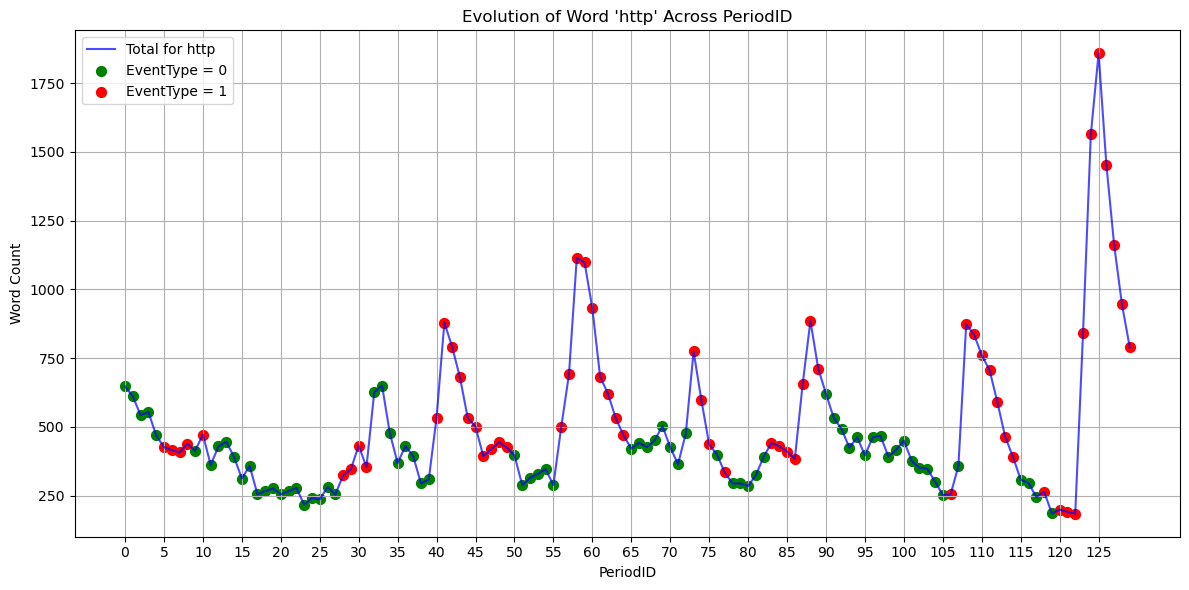

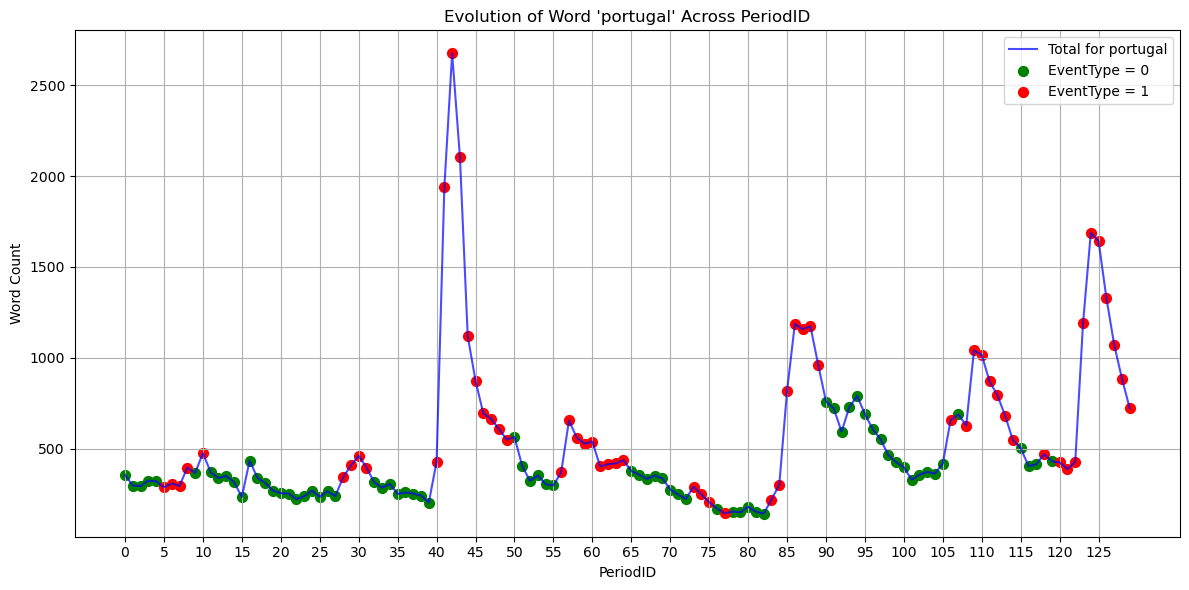

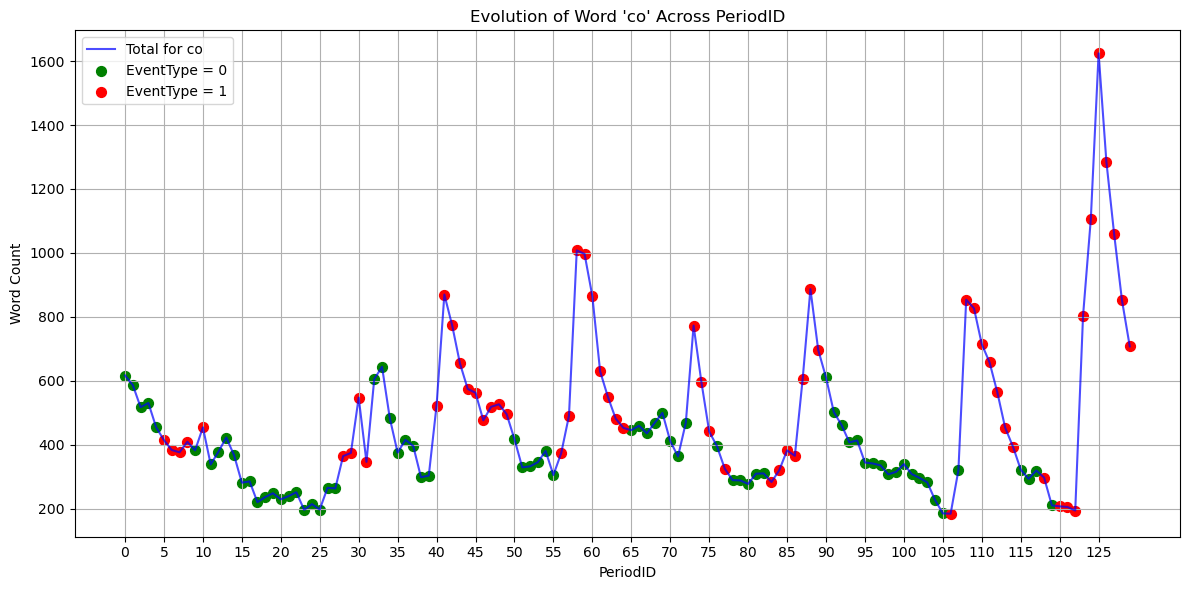

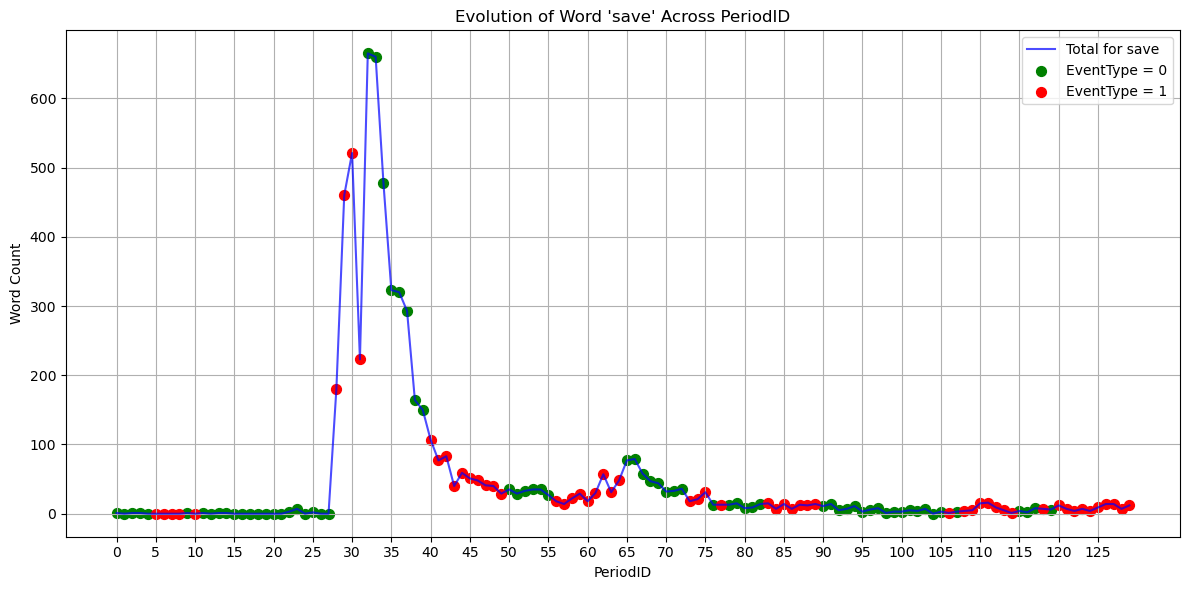

In [37]:
import matplotlib.pyplot as plt

# Select 5–10 most common meaningful words
meaningful_words = word_frequencies_sorted['word'].tolist()

# Track evolution of these words over PeriodID
word_evolution = pd.DataFrame()
for word in meaningful_words:
    for period_id in df['PeriodID'].unique():
        for event_type in df['EventType'].unique():
            tweets = df[(df['PeriodID'] == period_id) & (df['EventType'] == event_type)]['Tweet']
            if not tweets.empty:
                vectorizer = CountVectorizer(vocabulary=[word], stop_words=stop_words_list, lowercase=True)
                word_count = vectorizer.fit_transform(tweets).toarray().sum()
                word_evolution = pd.concat([word_evolution, pd.DataFrame({
                    'PeriodID': [period_id],
                    'EventType': [event_type],
                    'Word': [word],
                    'Count': [word_count]
                })], ignore_index=True)

# Generate one plot per word
for word in meaningful_words:
    word_data = word_evolution[word_evolution['Word'] == word]
    
    # Separate data for EventType = 0 and EventType = 1
    event_0 = word_data[word_data['EventType'] == 0]
    event_1 = word_data[word_data['EventType'] == 1]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot the combined trend line for the word
    plt.plot(
        word_data['PeriodID'], 
        word_data['Count'], 
        label=f"Total for {word}", 
        color="blue", 
        alpha=0.7
    )
    
    # Highlight EventType = 0 and EventType = 1
    plt.scatter(event_0['PeriodID'], event_0['Count'], color="green", label=f"EventType = 0", s=50)
    plt.scatter(event_1['PeriodID'], event_1['Count'], color="red", label=f"EventType = 1", s=50)
    
    # Add labels, title, and legend
    plt.title(f"Evolution of Word '{word}' Across PeriodID")
    plt.xlabel("PeriodID")
    plt.ylabel("Word Count")
    plt.legend()
    plt.grid(True)
    
    # Set x-ticks to show multiples of 5
    plt.xticks(range(0, int(word_evolution['PeriodID'].max()) + 1, 5))
    
    # Show the plot
    plt.tight_layout()
    plt.show()

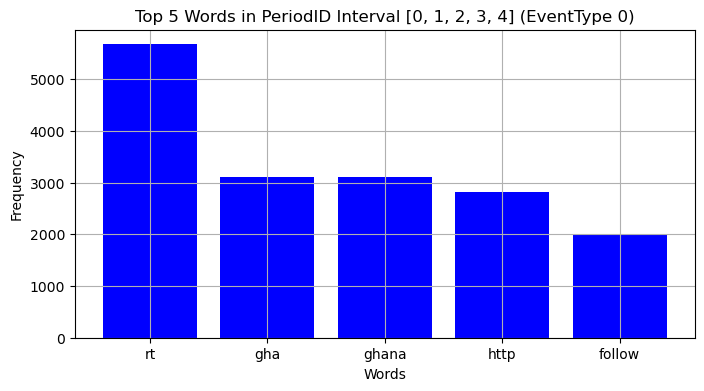

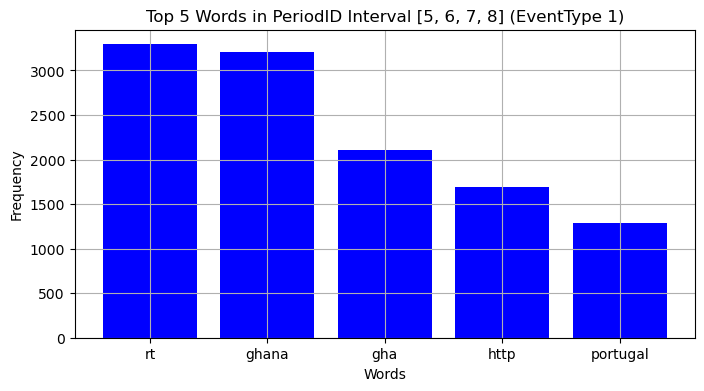

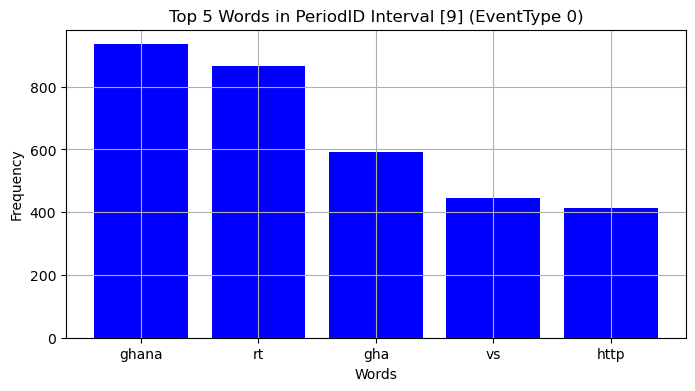

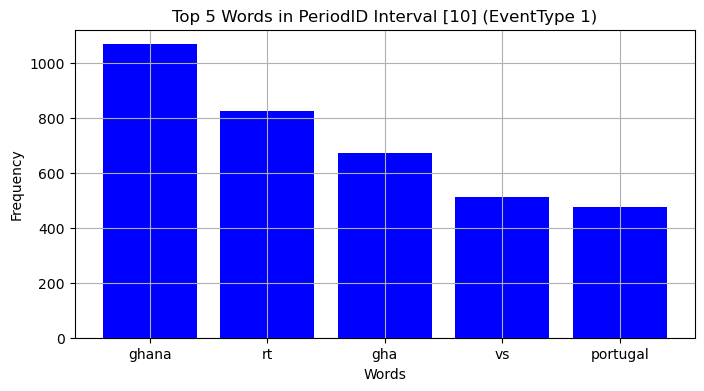

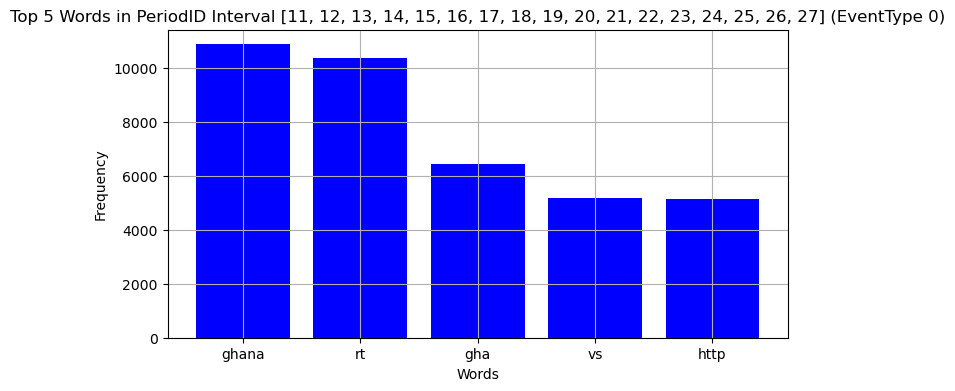

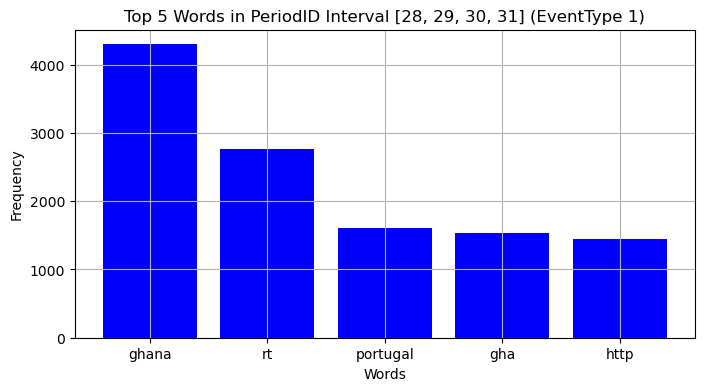

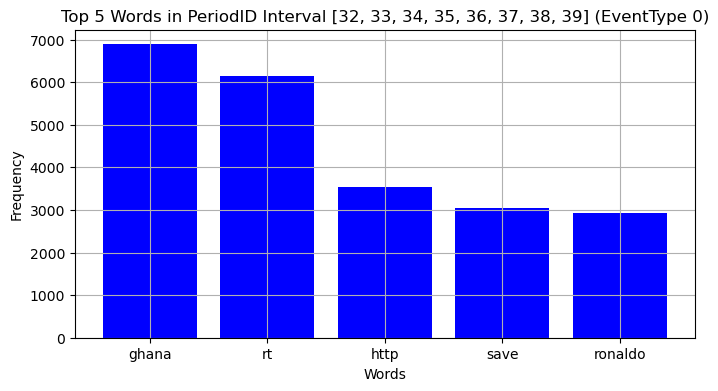

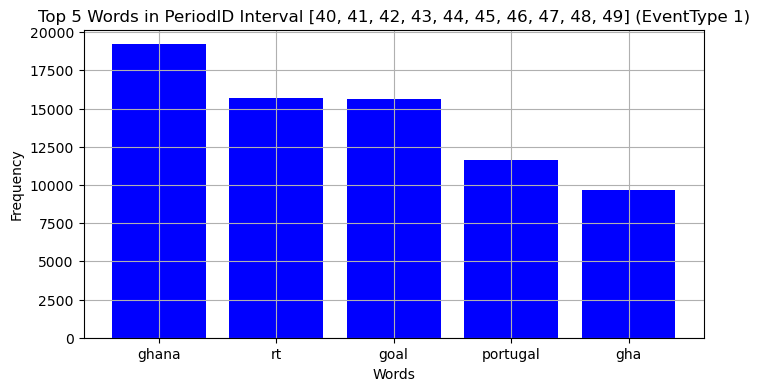

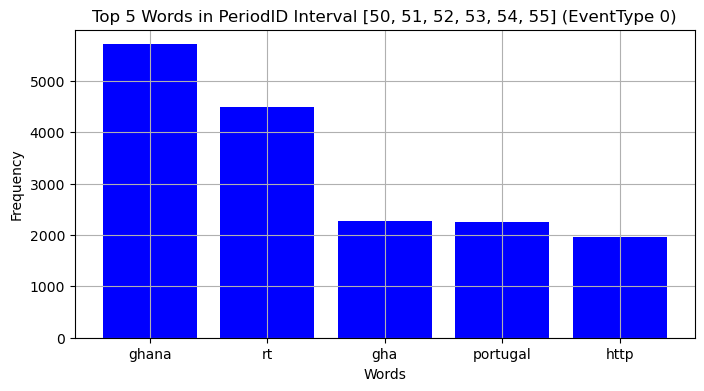

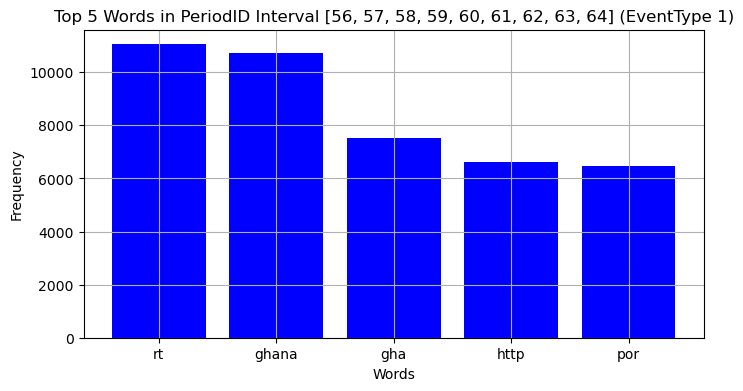

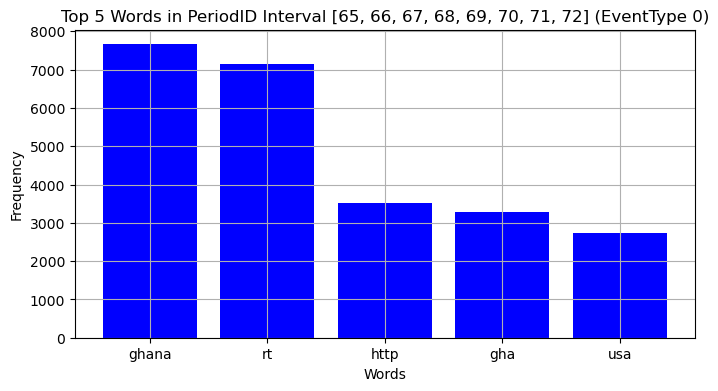

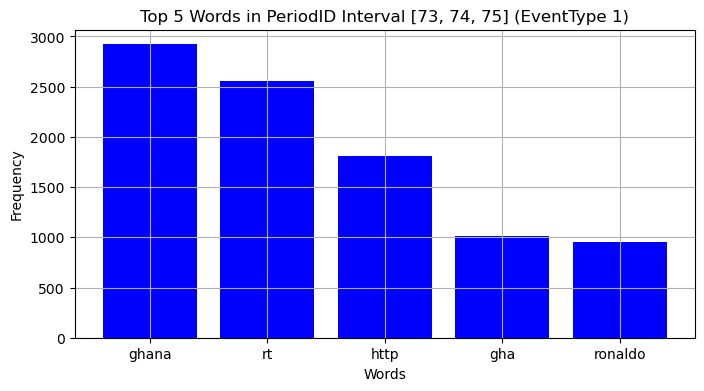

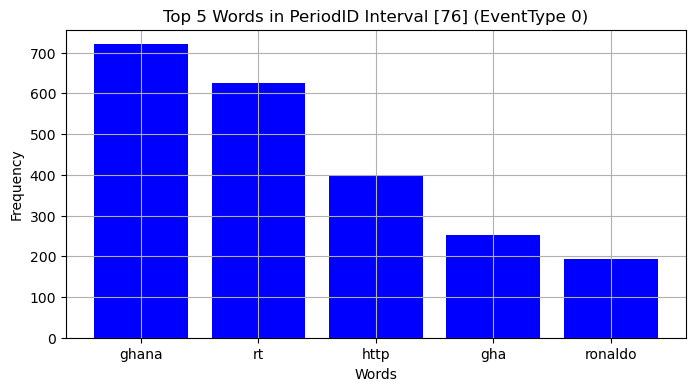

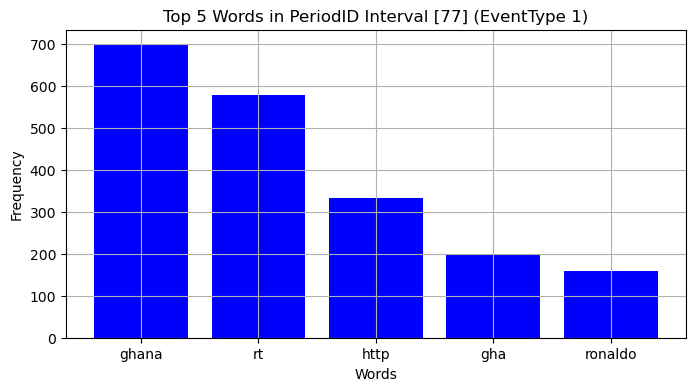

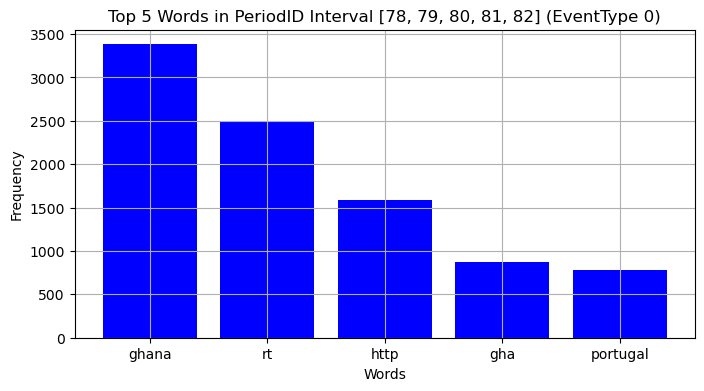

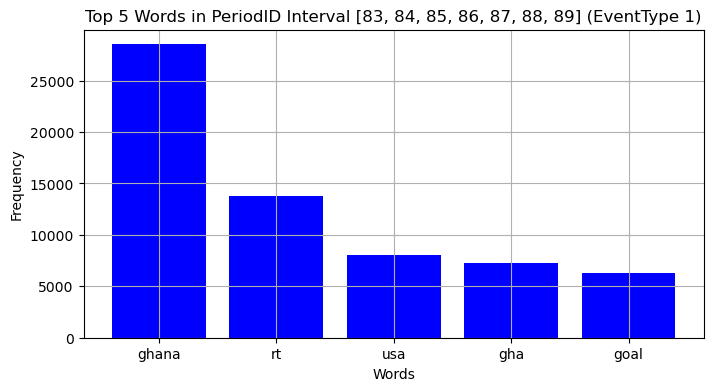

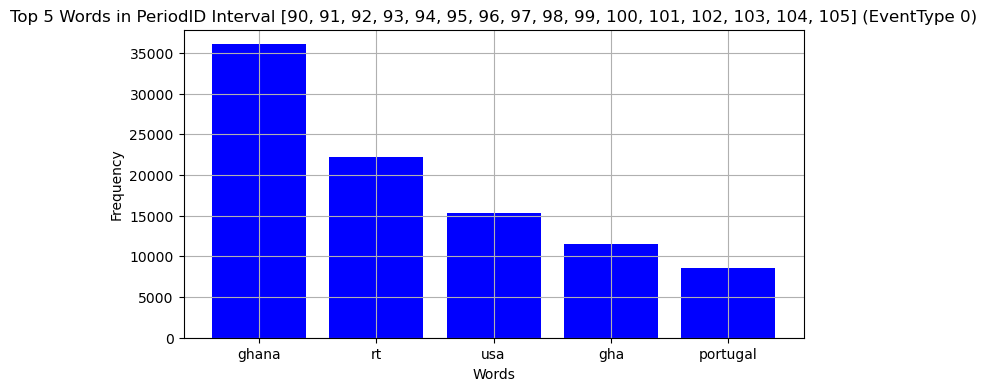

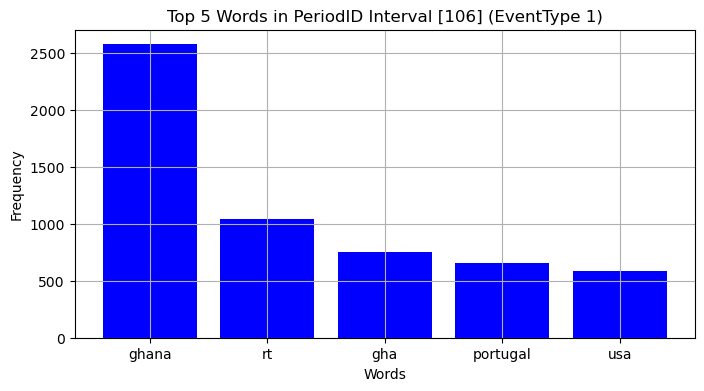

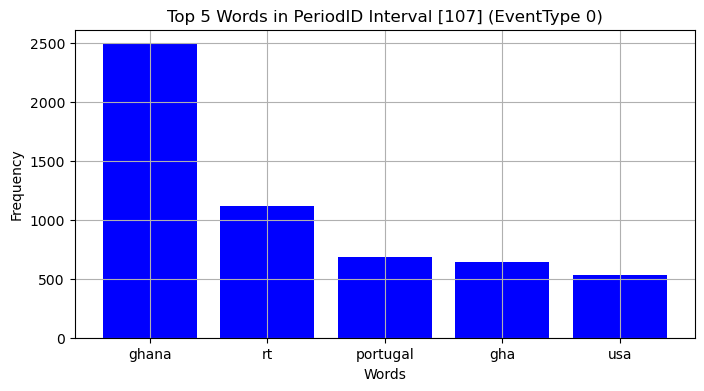

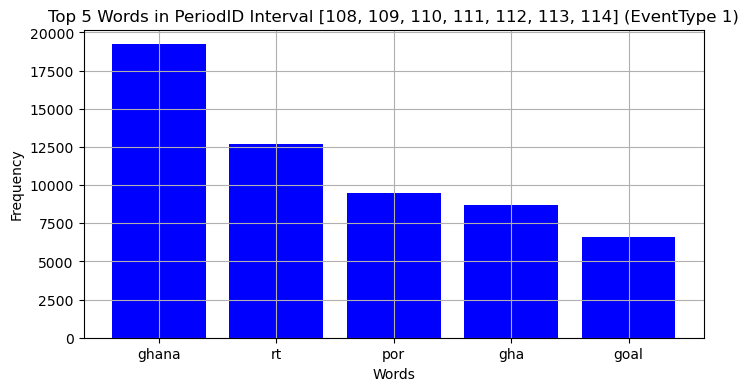

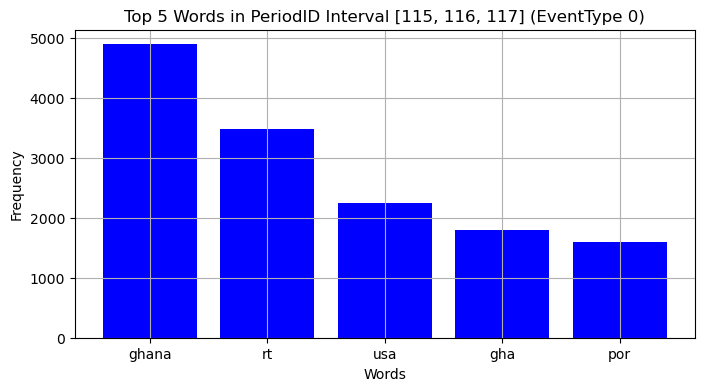

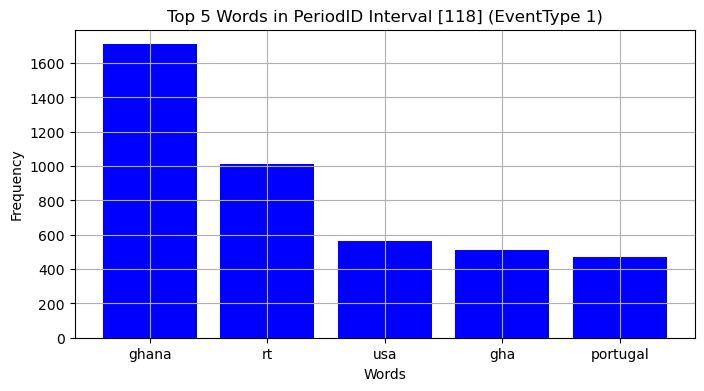

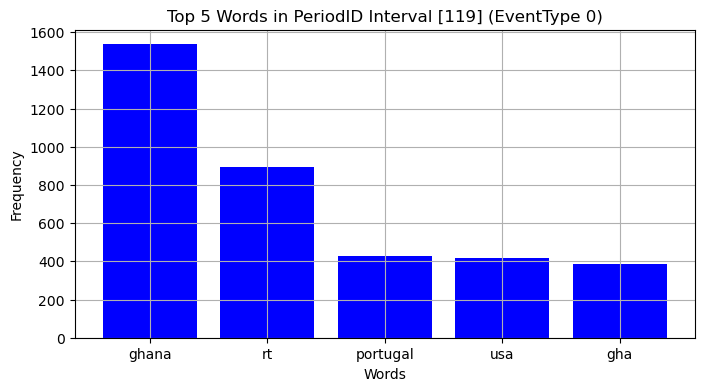

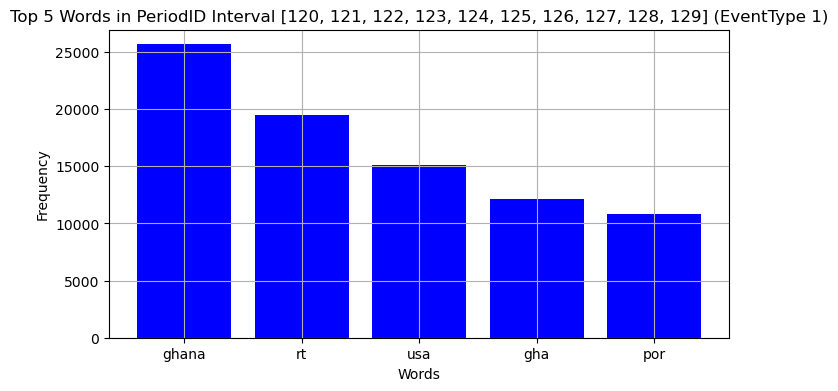

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd

# Initialize storage for intervals
intervals = []
current_interval = [df.iloc[0]['PeriodID']]
current_event_type = df.iloc[0]['EventType']

# Group PeriodID into consecutive intervals based on EventType
for idx, row in df.iterrows():
    if row['EventType'] == current_event_type:
        if row['PeriodID'] not in current_interval:  # Avoid duplicates
            current_interval.append(row['PeriodID'])
    else:
        intervals.append((current_interval, current_event_type))
        current_interval = [row['PeriodID']]
        current_event_type = row['EventType']
intervals.append((current_interval, current_event_type))  # Add the last interval

# Analyze and plot 5 most common words for each interval
for interval, event_type in intervals:
    # Filter tweets within the interval
    interval_tweets = df[df['PeriodID'].isin(interval)]['Tweet'].dropna()
    
    if interval_tweets.empty:
        continue
    
    # Tokenize and count word frequencies
    vectorizer = CountVectorizer(stop_words='english', lowercase=True)
    word_counts = vectorizer.fit_transform(interval_tweets)
    word_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(),
                              'count': word_counts.toarray().sum(axis=0)})

    # Get 5 most common words
    top_words = word_freq.sort_values(by='count', ascending=False).head(5)

    # Plot the words
    plt.figure(figsize=(8, 4))
    plt.bar(top_words['word'], top_words['count'], color="blue")
    plt.title(f"Top 5 Words in PeriodID Interval {interval} (EventType {event_type})")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

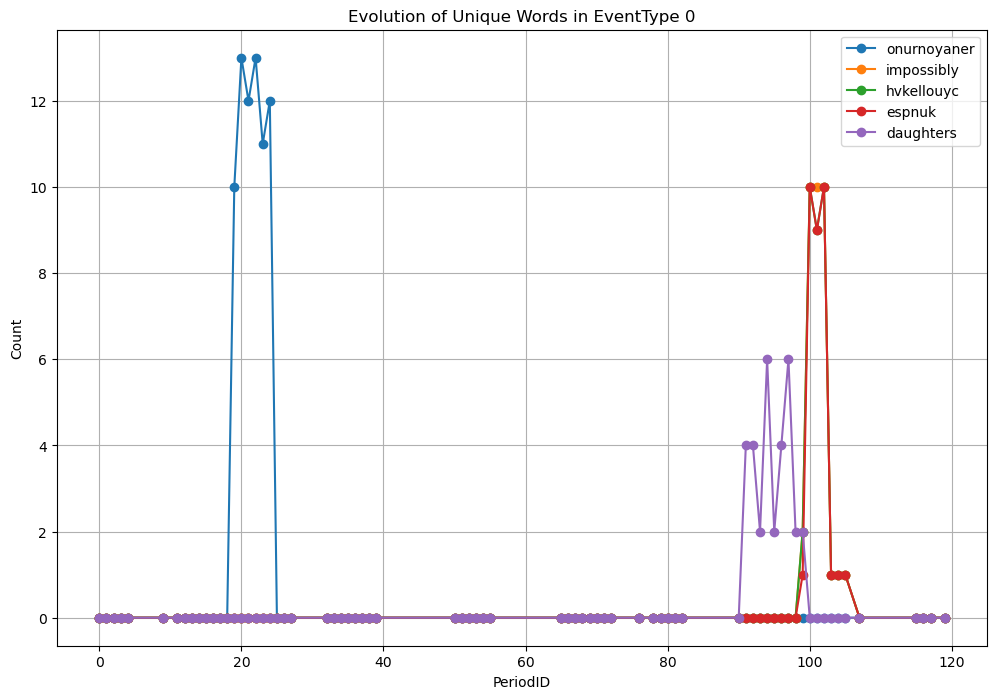

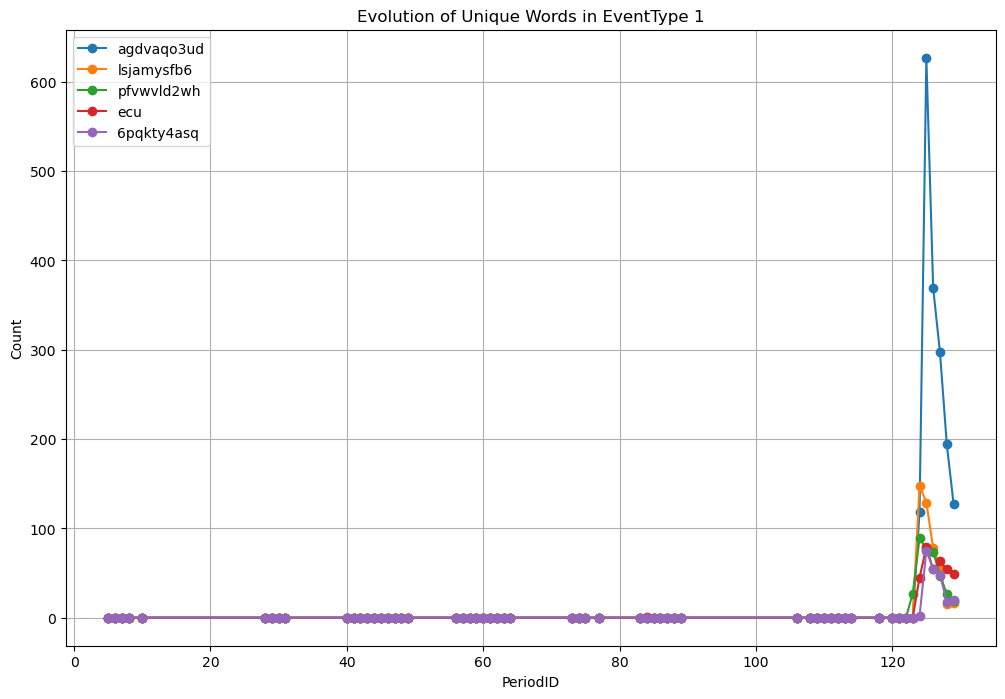

In [45]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Set minimum count threshold
min_count_threshold = 5

# Function to process unique words per EventType
def extract_unique_words(df, event_type, min_count):
    event_tweets = df[df['EventType'] == event_type]['Tweet']
    vectorizer = CountVectorizer(stop_words='english', lowercase=True)
    word_counts = vectorizer.fit_transform(event_tweets)
    
    # Use sparse operations to sum word counts
    word_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(),
                              'count': word_counts.sum(axis=0).A1})  # Avoid dense conversion
    
    # Filter words with a minimum count threshold
    word_freq = word_freq[word_freq['count'] >= min_count]
    
    # Identify words unique to this EventType
    opposite_event_tweets = df[df['EventType'] != event_type]['Tweet']
    opposite_vectorizer = CountVectorizer(vocabulary=vectorizer.get_feature_names_out(), stop_words='english', lowercase=True)
    opposite_word_counts = opposite_vectorizer.fit_transform(opposite_event_tweets)
    opposite_word_freq = pd.DataFrame({'word': opposite_vectorizer.get_feature_names_out(),
                                       'count': opposite_word_counts.sum(axis=0).A1})
    
    unique_words = word_freq[~word_freq['word'].isin(opposite_word_freq[opposite_word_freq['count'] > 0]['word'])]
    return unique_words.sort_values(by='count', ascending=False).head(5)

# Plot evolution of unique words for EventType 0 and 1
for event_type in df['EventType'].unique():
    unique_words = extract_unique_words(df, event_type, min_count_threshold)
    word_evolution = pd.DataFrame()

    for word in unique_words['word']:
        for period_id in df['PeriodID'].unique():
            tweets = df[(df['PeriodID'] == period_id) & (df['EventType'] == event_type)]['Tweet']
            if not tweets.empty:
                vectorizer = CountVectorizer(vocabulary=[word], stop_words='english', lowercase=True)
                word_count = vectorizer.fit_transform(tweets).sum()
                word_evolution = pd.concat([word_evolution, pd.DataFrame({
                    'PeriodID': [period_id],
                    'Word': [word],
                    'Count': [word_count]
                })], ignore_index=True)

    # Plot the evolution of unique words
    plt.figure(figsize=(12, 8))
    for word in unique_words['word']:
        subset = word_evolution[word_evolution['Word'] == word]
        plt.plot(subset['PeriodID'], subset['Count'], marker='o', label=word)

    plt.title(f"Evolution of Unique Words in EventType {event_type}")
    plt.xlabel("PeriodID")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()

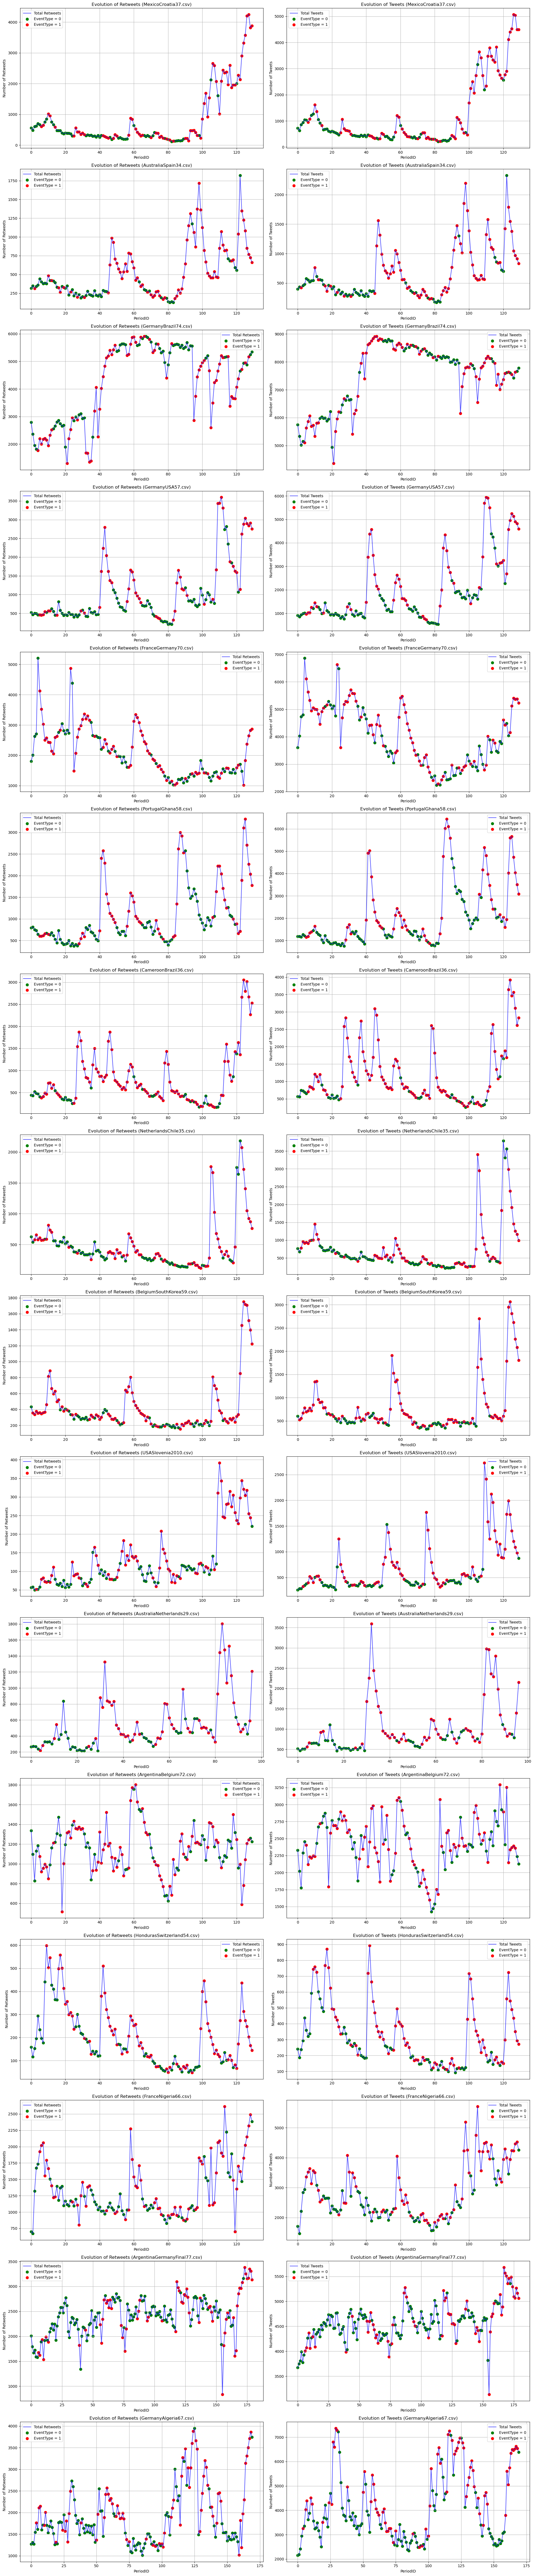

In [51]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the folder containing the CSV files
folder_path = "train_tweets/"

# Get the list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Set up the figure for inline plotting
fig, axes = plt.subplots(len(csv_files), 2, figsize=(20, len(csv_files) * 6))

# Loop through each CSV file and create plots
for idx, file_name in enumerate(csv_files):
    # Load the CSV file into a DataFrame
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    
    # Filter the dataframe to include only retweets
    retweets_df = df[df['Tweet'].str.contains('RT', na=False)]

    # Group data by PeriodID and EventType to calculate the number of retweets
    retweet_counts = retweets_df.groupby(['PeriodID', 'EventType']).size().reset_index(name='RetweetCount')

    # Remove rows where the number of retweets is zero
    retweet_counts = retweet_counts[retweet_counts['RetweetCount'] > 0]

    # Separate the data for EventType = 0 and EventType = 1 for retweets
    retweets_event_0 = retweet_counts[retweet_counts['EventType'] == 0]
    retweets_event_1 = retweet_counts[retweet_counts['EventType'] == 1]

    # Group data by PeriodID and EventType to calculate the number of tweets
    tweet_counts = df.groupby(['PeriodID', 'EventType']).size().reset_index(name='TweetCount')

    # Remove rows where the number of tweets is zero
    tweet_counts = tweet_counts[tweet_counts['TweetCount'] > 0]

    # Separate the data for EventType = 0 and EventType = 1 for tweets
    event_0 = tweet_counts[tweet_counts['EventType'] == 0]
    event_1 = tweet_counts[tweet_counts['EventType'] == 1]

    # Plot the retweets evolution
    ax_retweets = axes[idx, 0] if len(csv_files) > 1 else axes[0]
    ax_retweets.plot(
        retweet_counts['PeriodID'], 
        retweet_counts['RetweetCount'], 
        label="Total Retweets", 
        color="blue", 
        alpha=0.7
    )
    ax_retweets.scatter(retweets_event_0['PeriodID'], retweets_event_0['RetweetCount'], color="green", label="EventType = 0", s=50)
    ax_retweets.scatter(retweets_event_1['PeriodID'], retweets_event_1['RetweetCount'], color="red", label="EventType = 1", s=50)
    ax_retweets.set_title(f"Evolution of Retweets ({file_name})")
    ax_retweets.set_xlabel("PeriodID")
    ax_retweets.set_ylabel("Number of Retweets")
    ax_retweets.legend()
    ax_retweets.grid(True)

    # Plot the tweets evolution
    ax_tweets = axes[idx, 1] if len(csv_files) > 1 else axes[1]
    ax_tweets.plot(
        tweet_counts['PeriodID'], 
        tweet_counts['TweetCount'], 
        label="Total Tweets", 
        color="blue", 
        alpha=0.7
    )
    ax_tweets.scatter(event_0['PeriodID'], event_0['TweetCount'], color="green", label="EventType = 0", s=50)
    ax_tweets.scatter(event_1['PeriodID'], event_1['TweetCount'], color="red", label="EventType = 1", s=50)
    ax_tweets.set_title(f"Evolution of Tweets ({file_name})")
    ax_tweets.set_xlabel("PeriodID")
    ax_tweets.set_ylabel("Number of Tweets")
    ax_tweets.legend()
    ax_tweets.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Continue With pre processing : Noise Reduction: Remove retweets, duplicate tweets, mentions, and URLs, and remove non-ASCII characters ?? + see class imbalance + total count and how to handle it
# Tokenization and Stemming: Standard text-cleaning techniques ensure uniformity.
# Graph Representation. 